In [1]:
# Import necessary libraries.
import tensorflow as tf
import os
from tqdm import tqdm
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from keras.utils import np_utils             
import cv2
import math
import numpy as np
import pandas as pd
from glob import glob
from matplotlib import pyplot as plt
%matplotlib inline 
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, GlobalMaxPooling2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.optimizers import RMSprop, Adam
from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
# Selecting the project path for images 
project_path = '/content/drive/My Drive/train.zip'


In [3]:
# Making a temp directory for extracting the zip file 

!mkdir temp_train


In [4]:

# Mounting the google drive 

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
# Extracting the zip file in the temp directory

from zipfile import ZipFile
with ZipFile(project_path, 'r') as zip:
  zip.extractall('./temp_train')

In [2]:
# Reading the images and labels from the directory 
images_path = './temp_train/*/*.png'
images = glob(images_path)
imagesdata = []
labels = []
for img in images:
    imagesdata.append(cv2.resize(cv2.imread(img), (256, 256)))
    labels.append(img.split('/')[-2])
X_Images = np.asarray(imagesdata)
Y_labels = pd.DataFrame(labels)

In [3]:
# Data Preprocessing Normalisation , Gaussian blurring and visualise 
# Normalization of the Image Data
X_Images = X_Images.astype('float32') / 255


In [8]:
X_Images.shape

(4750, 256, 256, 3)

In [9]:
# Gaussian blurring of the array 
blurredimages = []

for img in images:
    blurredimages.append(cv2.GaussianBlur(cv2.imread(img),(5,5),0))


-----Actual Image-----


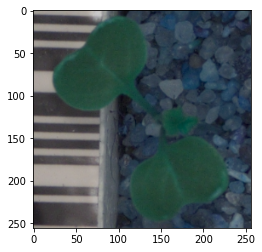

In [ ]:
# Visualising the data 
print("-----Actual Image-----")
plt.imshow(X_Images[1])


-----blurred Image-----


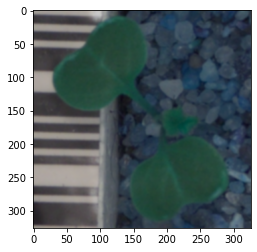

In [ ]:
print("-----blurred Image-----")
plt.imshow(blurredimages[1])


In [4]:
# Converting labels to numbers as per keras and one hot encoding
encoder = LabelEncoder()
encoder.fit(Y_labels[0])
encoded_labels = encoder.transform(Y_labels[0])
categorical_labels = np_utils.to_categorical(encoded_labels)

In [5]:
# Training test split . Validation will be used from the train data while running the model 
from sklearn.model_selection import train_test_split

x_train,x_test,y_train,y_test=train_test_split(X_Images,categorical_labels,test_size=0.3,random_state=7)


In [12]:
# Print the label for y_train[0].

print(y_train[0])

[0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]


In [6]:
# Building the CNN

# Initialize model
model = tf.keras.models.Sequential()

#Add 1st Conv Layer
model.add(tf.keras.layers.Conv2D(64, kernel_size=(3, 3), input_shape=(256, 256, 3), activation='relu'))

#Add 2nd Conv Layer
model.add(tf.keras.layers.Conv2D(64, kernel_size=(3,3), activation='relu'))

#normalize data
model.add(tf.keras.layers.BatchNormalization())

#Add Max Pool layer
model.add(tf.keras.layers.MaxPool2D(pool_size=(2,2)))

#Add 3rd Conv Layer
model.add(tf.keras.layers.Conv2D(128, kernel_size=(3,3), activation='relu'))

#normalize data
model.add(tf.keras.layers.BatchNormalization())

#Add Max Pool layer
model.add(tf.keras.layers.MaxPool2D(pool_size=(2,2)))

#Add 4th Conv Layer
model.add(tf.keras.layers.Conv2D(256, kernel_size=(3,3), activation='relu'))

#normalize data
model.add(tf.keras.layers.BatchNormalization())

#Add Max Pool layer
model.add(tf.keras.layers.MaxPool2D(pool_size=(2,2)))

#Add Global Max Pool layer
model.add(tf.keras.layers.GlobalMaxPool2D())

#Flatten the data
model.add(tf.keras.layers.Flatten())

#Add 1st dense layer
model.add(tf.keras.layers.Dense(128, activation='relu'))

#normalize data
model.add(tf.keras.layers.BatchNormalization())

#Add Dropout
model.add(tf.keras.layers.Dropout(0.3))

#Add 2nd dense layer
model.add(tf.keras.layers.Dense(128, activation='relu'))

#normalize data
model.add(tf.keras.layers.BatchNormalization())

#Add Dropout
model.add(tf.keras.layers.Dropout(0.3))

#Add Output Layer
model.add(tf.keras.layers.Dense(12, activation='softmax'))

In [7]:
#Adding Early stopping callback to the fit function is going to stop the training,

from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', min_delta=0.001, patience=10)

#Adding Model Checkpoint callback to the fit function is going to save the weights whenever val_loss achieves a new low 


model_checkpoint =  ModelCheckpoint('cifar_cnn_checkpoint_{epoch:02d}_loss{val_loss:.4f}.h5',
                                                           monitor='val_loss',
                                                           verbose=1,
                                                           save_best_only=True,
                                                           save_weights_only=True,
                                                           mode='auto',
                                                           period=1)

In [8]:
#Set optimizer and loss function. (Use Adam optimizer and categorical crossentropy.)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [9]:
model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 254, 254, 64)      1792      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 252, 252, 64)      36928     
_________________________________________________________________
batch_normalization (BatchNo (None, 252, 252, 64)      256       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 126, 126, 64)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 124, 124, 128)     73856     
_________________________________________________________________
batch_normalization_1 (Batch (None, 124, 124, 128)     512       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 62, 62, 128)       0

Epoch 1/100
84/84 [==============================] - 65s 313ms/step - loss: 2.6561 - accuracy: 0.2094 - val_loss: 4.5815 - val_accuracy: 0.1323

Epoch 00001: val_loss improved from inf to 4.58147, saving model to cifar_cnn_checkpoint_01_loss4.5815.h5
Epoch 2/100
84/84 [==============================] - 22s 263ms/step - loss: 1.6567 - accuracy: 0.4258 - val_loss: 7.9211 - val_accuracy: 0.1188

Epoch 00002: val_loss did not improve from 4.58147
Epoch 3/100
84/84 [==============================] - 22s 264ms/step - loss: 1.4360 - accuracy: 0.4983 - val_loss: 9.4697 - val_accuracy: 0.1188

Epoch 00003: val_loss did not improve from 4.58147
Epoch 4/100
84/84 [==============================] - 22s 266ms/step - loss: 1.0891 - accuracy: 0.6206 - val_loss: 8.8253 - val_accuracy: 0.1188

Epoch 00004: val_loss did not improve from 4.58147
Epoch 5/100
84/84 [==============================] - 22s 267ms/step - loss: 1.0820 - accuracy: 0.6391 - val_loss: 7.4613 - val_accuracy: 0.1203

Epoch 00005: val

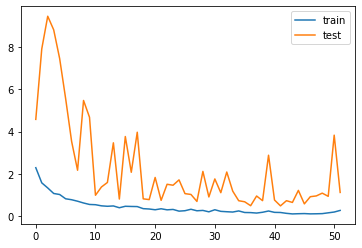

In [10]:
# Model fit with 100 epochs and Validation split happening in the train data
history = model.fit(x_train,
                    y_train,
                    batch_size=32,
                    epochs=100,
                    validation_split=0.2,
                    shuffle=True,
                    verbose=1,
                    callbacks=[early_stopping,model_checkpoint])

# plot training history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [11]:
# Score trained model.
scores = model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])


45/45 [==============================] - 5s 117ms/step - loss: 1.0276 - accuracy: 0.7319
Test loss: 1.0275517702102661
Test accuracy: 0.7319298386573792


In [12]:
# Predicting Y value based on the optimised model derived above
y_pred = model.predict(x_test)

In [15]:
# Converting predicted value back to original classification value by reverse transformation 
y_preds = np.argmax(y_pred, axis=1)
y_predsstring = encoder.inverse_transform(y_preds)

In [16]:
# Converting test value back to original classification value by reverse transformation 

Y_test = np.argmax(y_test, axis=1)
y_actualstring = encoder.inverse_transform(Y_test)

In [18]:
# Printing the confusion matrix 
from sklearn.metrics import classification_report, confusion_matrix
print("=== Confusion Matrix ===")
cm = confusion_matrix(Y_test, y_preds)
print(cm)

=== Confusion Matrix ===
[[ 30   0   3   0   2   0  34   0   0   0   0   0]
 [  5  35  41   1   0   3   0   0   0   5   0   9]
 [  0   0  85   1   0   0   1   0   0   0   0   1]
 [  2   0   5 181   0   1   8   0   1   0   0   2]
 [  8   0   6   0  57   1   3   0   0   0   0   4]
 [  0   0   0   0   0 129   5   0   0   0   0   0]
 [  6   0   1   0   3   1 202   0   0   0   0   0]
 [  7   0   0   1   0   0   2  42   0   0   0  14]
 [  0   0  15   7   0   0  17   0 108   2   0   3]
 [  0   0  14  12   0   0   6   0   4  34   0   0]
 [ 51   0   9   7   0  11  26   0   1   2  43   0]
 [  5   0   2   0   0   0   0   0   1   0   0  97]]


In [19]:
print("=== Classification Report ===")
print(classification_report(Y_test, y_preds))

=== Classification Report ===
              precision    recall  f1-score   support

           0       0.26      0.43      0.33        69
           1       1.00      0.35      0.52        99
           2       0.47      0.97      0.63        88
           3       0.86      0.91      0.88       200
           4       0.92      0.72      0.81        79
           5       0.88      0.96      0.92       134
           6       0.66      0.95      0.78       213
           7       1.00      0.64      0.78        66
           8       0.94      0.71      0.81       152
           9       0.79      0.49      0.60        70
          10       1.00      0.29      0.45       150
          11       0.75      0.92      0.83       105

    accuracy                           0.73      1425
   macro avg       0.79      0.69      0.69      1425
weighted avg       0.81      0.73      0.72      1425



-----Actual Value-----
Common Chickweed
-----Predicted  Value-----
Common Chickweed


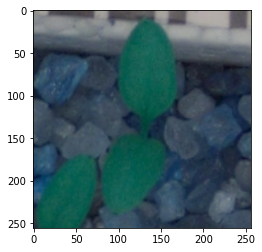

In [20]:
# Printing the image and the predicted and actual values for x_test 2 , 3, 33,36,59 as per assignment request 
plt.imshow(x_test[2])
print("-----Actual Value-----")
print(y_actualstring[2])
print("-----Predicted  Value-----")
print(y_predsstring[2])

-----Actual Value-----
Scentless Mayweed
-----Predicted  Value-----
Loose Silky-bent


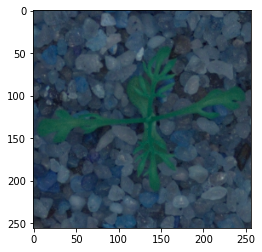

In [21]:
plt.imshow(x_test[3])
print("-----Actual Value-----")
print(y_actualstring[3])
print("-----Predicted  Value-----")
print(y_predsstring[3])

-----Actual Value-----
Common Chickweed
-----Predicted  Value-----
Common Chickweed


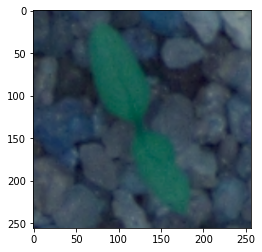

In [22]:
plt.imshow(x_test[33])
print("-----Actual Value-----")
print(y_actualstring[33])
print("-----Predicted  Value-----")
print(y_predsstring[33])

-----Actual Value-----
Small-flowered Cranesbill
-----Predicted  Value-----
Loose Silky-bent


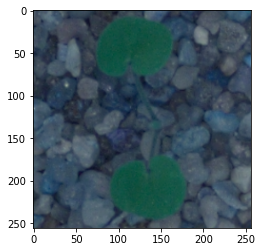

In [23]:
plt.imshow(x_test[36])
print("-----Actual Value-----")
print(y_actualstring[36])
print("-----Predicted  Value-----")
print(y_predsstring[36])

-----Actual Value-----
Sugar beet
-----Predicted  Value-----
Sugar beet


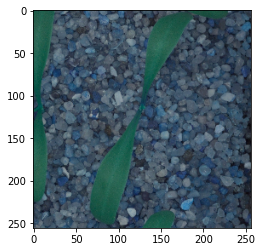

In [24]:
plt.imshow(x_test[59])
print("-----Actual Value-----")
print(y_actualstring[59])
print("-----Predicted  Value-----")
print(y_predsstring[59])